# Folder Setup

In [ ]:
!df -h /content

Filesystem      Size  Used Avail Use% Mounted on
overlay         236G   38G  199G  16% /


In [ ]:
!cp "/content/drive/MyDrive/Deep Learning/super-resolution-in-video-games/subset.zip" /content/

In [ ]:
!unzip -q /content/subset.zip -d /content/

# Extra Installs

In [ ]:
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 869.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

# Imports

In [ ]:
import lpips  # Learned Perceptual Image Patch Similarity
import time
import platform
import pandas as pd
import seaborn as sns

import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Variables, Functions and Classes Setup


## SRCNN

In [ ]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, kernel_size=5, padding=2),
        )

    def forward(self, x):
        return self.model(x)


## SRDataset Object

In [ ]:
class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, transform=None):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.filenames = sorted(os.listdir(lr_dir))
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        name = self.filenames[idx]
        lr_path = os.path.join(self.lr_dir, self.filenames[idx])
        hr_path = os.path.join(self.hr_dir, self.filenames[idx])

        lr = Image.open(lr_path).convert("RGB")
        hr = Image.open(hr_path).convert("RGB")

        if self.transform:
            lr = self.transform(lr)
            hr = self.transform(hr)

        return {"name": name, "lr": lr, "hr": hr}

# Load Trained Model and Test Data

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SRCNN().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/Deep Learning/SRCNN/best_srcnn.pth"))
model.eval()

SRCNN(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)

In [ ]:
test_dataset = SRDataset(
    lr_dir="/content/subset/test/lr",
    hr_dir="/content/subset/test/hr",
    transform=transforms.ToTensor()
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Model Evaluation

In [ ]:
import os
from torchvision.transforms.functional import to_pil_image

lpips_loss_fn = lpips.LPIPS(net='alex').to(device)

def sharpen_tensor(img_tensor: torch.Tensor) -> torch.Tensor:
    kernel = torch.tensor([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]], dtype=torch.float32, device=img_tensor.device)
    kernel = kernel.expand(3, 1, 3, 3)
    return F.conv2d(img_tensor, kernel, padding=1, groups=3)

def evaluate(model, dataloader, device, save_dir="results"):
    results = []

    # Diretórios para salvar imagens
    normal_dir = os.path.join(save_dir, "SRCNN")
    sharp_dir = os.path.join(save_dir, "SRCNN_sharp")
    os.makedirs(normal_dir, exist_ok=True)
    os.makedirs(sharp_dir, exist_ok=True)

    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader):
            lr = batch["lr"].to(device)
            hr = batch["hr"].to(device)
            name = batch["name"][0]  # batch size 1, name é lista

            bicubic = F.interpolate(lr, size=hr.shape[-2:], mode='bicubic', align_corners=False)

            # Inferência
            start_time = time.time()
            sr = model(bicubic).clamp(0, 1)
            inference_time = time.time() - start_time

            # Sharpened
            sr_sharp = sharpen_tensor(sr).clamp(0, 1)

            # Métricas
            hr_np = hr.squeeze(0).permute(1, 2, 0).cpu().numpy()
            sr_np = sr.squeeze(0).permute(1, 2, 0).cpu().numpy()
            bicubic_np = bicubic.squeeze(0).permute(1, 2, 0).cpu().numpy()

            psnr_bic = psnr(hr_np, bicubic_np, data_range=1.0)
            psnr_sr = psnr(hr_np, sr_np, data_range=1.0)
            ssim_bic = ssim(hr_np, bicubic_np, channel_axis=2, data_range=1.0)
            ssim_sr = ssim(hr_np, sr_np, channel_axis=2, data_range=1.0)
            sr_lpips = lpips_loss_fn(sr, hr).item()

            # Salvar saída SRCNN
            sr_img = to_pil_image(sr.squeeze(0).cpu())
            sr_img.save(os.path.join(normal_dir, name))

            # Salvar saída sharpened
            sr_sharp_img = to_pil_image(sr_sharp.squeeze(0).cpu())
            sr_sharp_img.save(os.path.join(sharp_dir, name))

            results.append({
                "image": name,
                "psnr_bicubic": psnr_bic,
                "psnr_srcnn": psnr_sr,
                "ssim_bicubic": ssim_bic,
                "ssim_srcnn": ssim_sr,
                "lpips_srcnn": sr_lpips,
                "inference_time_s": inference_time
            })

    return results

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


In [ ]:
def print_system_info():
    print(f"OS: {platform.system()} {platform.release()}")
    print(f"Processor: {platform.processor()}")
    print(f"Python version: {platform.python_version()}")
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"GPU Name: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0)/1024**3:.2f} GB")
        print(f"GPU Memory Reserved: {torch.cuda.memory_reserved(0)/1024**3:.2f} GB")
        print(f"GPU Memory Total: {torch.cuda.get_device_properties(0).total_memory/1024**3:.2f} GB")
        print(f"GPU Memory Free: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_reserved(0))/1024**3:.2f} GB")

print_system_info()

OS: Linux 6.1.123+
Processor: x86_64
Python version: 3.11.12
PyTorch version: 2.6.0+cu124
CUDA available: True
GPU Name: Tesla T4
GPU Memory Allocated: 0.08 GB
GPU Memory Reserved: 2.33 GB
GPU Memory Total: 14.74 GB
GPU Memory Free: 12.41 GB


In [ ]:
results = evaluate(model, test_loader, device)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame(results)
df.head()

print("Médias das métricas:")
print(df[["psnr_bicubic", "psnr_srcnn", "ssim_bicubic", "ssim_srcnn", "lpips_srcnn", "inference_time_s"]].mean())

Médias das métricas:
psnr_bicubic        24.690924
psnr_srcnn          24.940910
ssim_bicubic         0.747644
ssim_srcnn           0.741019
lpips_srcnn          0.313428
inference_time_s     0.000573
dtype: float64


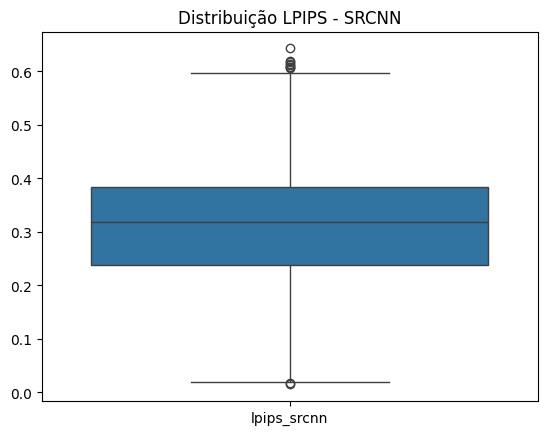

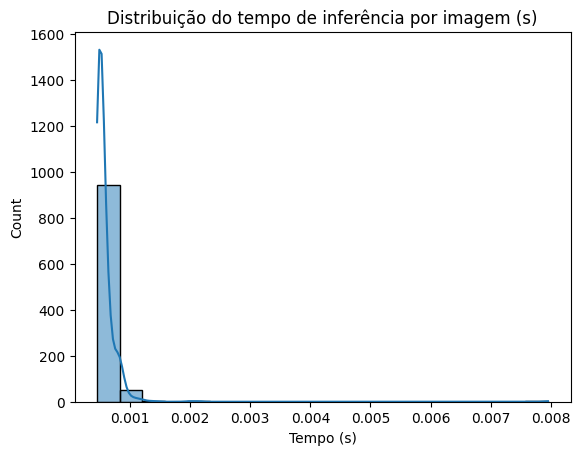

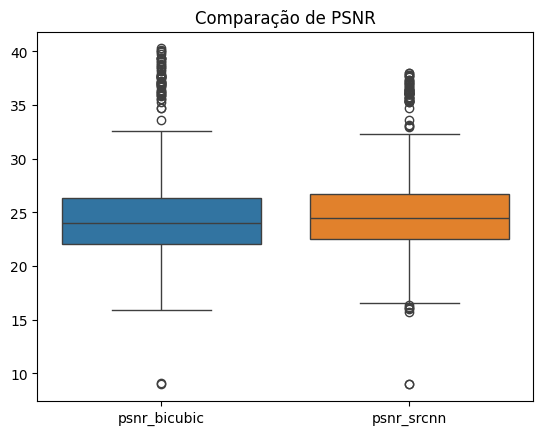

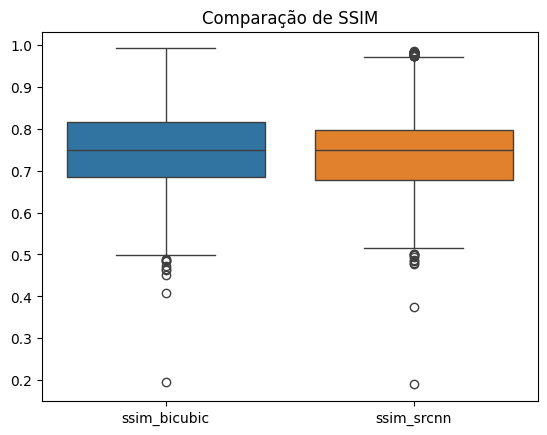

In [ ]:
# Boxplots
sns.boxplot(data=df[["lpips_srcnn"]])
plt.title("Distribuição LPIPS - SRCNN")
plt.show()

sns.histplot(df["inference_time_s"], bins=20, kde=True)
plt.title("Distribuição do tempo de inferência por imagem (s)")
plt.xlabel("Tempo (s)")
plt.show()

# Gráfico comparativo
sns.boxplot(data=df[["psnr_bicubic", "psnr_srcnn"]])
plt.title("Comparação de PSNR")
plt.show()

sns.boxplot(data=df[["ssim_bicubic", "ssim_srcnn"]])
plt.title("Comparação de SSIM")
plt.show()

In [ ]:
def show_comparison(batch, sr_tensor):
    lr = batch["lr"].squeeze(0).permute(1,2,0).cpu().numpy()
    hr = batch["hr"].squeeze(0).permute(1,2,0).cpu().numpy()
    sr = sr_tensor.squeeze(0).permute(1,2,0).cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(25,10))
    axs[0].imshow(lr)
    axs[0].set_title("Low-Res (480, 270)")
    axs[1].imshow(sr)
    axs[1].set_title("SRCNN (1920, 1080)")
    axs[2].imshow(hr)
    axs[2].set_title("High-Res (1920, 1080)")
    plt.show()


counter = 0
for batch in test_loader:
    lr = batch["lr"].to(device)
    hr = batch["hr"].to(device)
    bicubic = F.interpolate(lr, size=hr.shape[-2:], mode='bicubic', align_corners=False)

    with torch.no_grad():
        sr = model(bicubic).clamp(0, 1)

    show_comparison(batch, sr)
    if counter == 5:
        break
    counter += 1

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import shutil

src = "/content/results"
dst = "/content/drive/MyDrive/Deep Learning/SRCNN/results"

shutil.copytree(src, dst, dirs_exist_ok=True)
print("Resultados copiados para o Google Drive com sucesso.")

✅ Resultados copiados para o Google Drive com sucesso.
